Plan:
    
* extract head
* extract eyes
* PNP projection


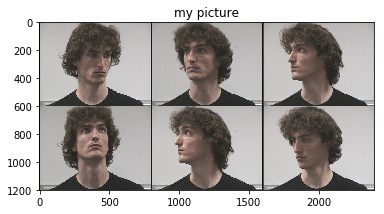

6


In [40]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
import math
import dlib
import cv2

#TEST PICTURE
img = cv2.imread('test2.png')
test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(test)
plt.title('my picture')
plt.show()

#Model for face detect
predictor_path = 'faceLandmarkModel.dat'

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

def analyseFace( img, quality=1, offset=(0,0)):
    dets = detector(np.array(img), quality)
    result=[]
    for k, d in enumerate(dets):
        instantFacePOI = np.zeros((7,2),dtype=np.float32)
        eyeCorners=np.zeros((2,2,2),dtype=np.float32)
        # Get the landmarks/parts for the face in box d.
        shape = predictor(np.array(img), d)
        #oreille droite
        instantFacePOI[0][0]=shape.part(0).x+offset[0];
        instantFacePOI[0][1]=shape.part(0).y+offset[1];
        #oreille gauche
        instantFacePOI[1][0]=shape.part(16).x+offset[0];
        instantFacePOI[1][1]=shape.part(16).y+offset[1];
        #nez
        instantFacePOI[2][0]=shape.part(30).x+offset[0];
        instantFacePOI[2][1]=shape.part(30).y+offset[1];
        #bouche gauche
        instantFacePOI[3][0]=shape.part(48).x+offset[0];
        instantFacePOI[3][1]=shape.part(48).y+offset[1];
        #bouche droite
        instantFacePOI[4][0]=shape.part(54).x+offset[0];
        instantFacePOI[4][1]=shape.part(54).y+offset[1];

        leftEyeX=0
        leftEyeY=0
        for i in range(36, 42):
            leftEyeX+=shape.part(i).x
            leftEyeY+=shape.part(i).y
        leftEyeX=int(leftEyeX/6.0)
        leftEyeY=int(leftEyeY/6.0)
        eyeCorners[0][0]=[shape.part(36).x+offset[0],shape.part(36).y+offset[1]]
        eyeCorners[0][1]=[shape.part(39).x+offset[0],shape.part(39).y+offset[1]]

        instantFacePOI[5][0]=leftEyeX+offset[0];
        instantFacePOI[5][1]=leftEyeY+offset[1];

        rightEyeX=0
        rightEyeY=0
        for i in range(42, 48):
            rightEyeX+=shape.part(i).x
            rightEyeY+=shape.part(i).y
        rightEyeX=int(rightEyeX/6.0)
        rightEyeY=int(rightEyeY/6.0)
        eyeCorners[1][0]=[shape.part(42).x+offset[0],shape.part(42).y+offset[1]]
        eyeCorners[1][1]=[shape.part(45).x+offset[0],shape.part(45).y+offset[1]]
        instantFacePOI[6][0]=rightEyeX+offset[0];
        instantFacePOI[6][1]=rightEyeY+offset[1];
        data=[instantFacePOI, (int(d.left()+offset[0]),int(d.top()+offset[1]),int(d.right()+offset[0]),int(d.bottom()+offset[1])),eyeCorners]
        result.append(data)
    return result

faces_data= analyseFace(test)
print(len(faces_data))

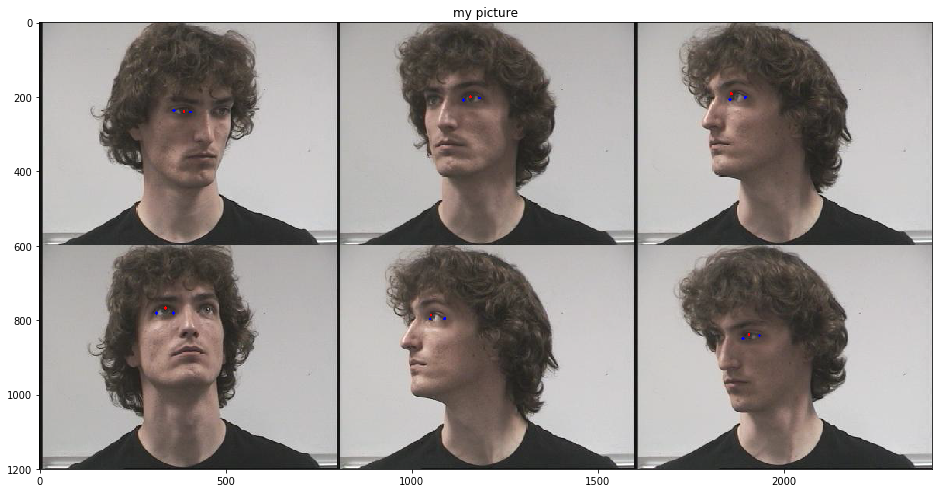

In [41]:

import operator

kGradientThreshold = 10.0
kWeightBlurSize = 5;
maxEyeSize=10;

def computeGradient(img):
    out = np.zeros((img.shape[0],img.shape[1]),dtype=np.float32) #create a receiver array
    if img.shape[0] < 2 or img.shape[1] < 2: # TODO I'm not sure that secure out of range
        print("EYES too small")
        return out
    for y in range(0,out.shape[0]):
        out[y][0]=img[y][1]-img[y][0]
        for x in range(1,out.shape[1]-1):
            out[y][x]=(img[y][x+1]-img[y][x-1])/2.0
        out[y][out.shape[1]-1]=img[y][out.shape[1]-1]-img[y][out.shape[1]-2]
    return out



def testPossibleCentersFormula(x, y, weight, gx, gy, out):
    for cy in range(0,out.shape[0]):
        for cx in range(0,out.shape[1]):
            if x==cx and y==cy :
                continue
            dx= x-cx
            dy= y-cy
            magnitude= math.sqrt(dx*dx+dy*dy)
            dx=dx/magnitude
            dy=dy/magnitude
            dotProduct=dx*gx+dy*gy
            dotProduct=max(0.0, dotProduct)
            out[cy][cx]+=dotProduct*dotProduct*weight[cy][cx]




def findEyeCenter(eyeImage, offset):
    if (len(eyeImage.shape) <= 0 or eyeImage.shape[0] <= 0 or eyeImage.shape[1] <= 0):
        return tuple(map(operator.add, (0, 0), offset))
    eyeImg = np.asarray(cv2.cvtColor(eyeImage, cv2.COLOR_BGR2GRAY))
    eyeImg = eyeImg.astype(np.float32)
    scaleValue=1.0;
    if(eyeImg.shape[0] > maxEyeSize or eyeImg.shape[1] > maxEyeSize):
        scaleValue=max(maxEyeSize/float(eyeImg.shape[0]),maxEyeSize/float(eyeImg.shape[1]))
        eyeImg=cv2.resize(eyeImg,None, fx=scaleValue,fy= scaleValue, interpolation = cv2.INTER_AREA)



    gradientX= computeGradient(eyeImg)
    gradientY= np.transpose(computeGradient(np.transpose(eyeImg)))
    gradientMatrix=matrixMagnitude(gradientX, gradientY)

    gradientThreshold=computeDynamicThreshold(gradientMatrix,kGradientThreshold)
    #Normalisation
    for y in range(0,eyeImg.shape[0]):  #Iterate through rows
        for x in range(0,eyeImg.shape[1]):  #Iterate through columns
            if(gradientMatrix[y][x]>gradientThreshold):
                gradientX[y][x]=gradientX[y][x]/gradientMatrix[y][x]
                gradientY[y][x]=gradientY[y][x]/gradientMatrix[y][x]
            else:
                gradientX[y][x]=0.0
                gradientY[y][x]=0.0

    #Invert and blur befor algo
    weight = cv2.GaussianBlur(eyeImg,(kWeightBlurSize,kWeightBlurSize),0)
    for y in range(0,weight.shape[0]):  #Iterate through rows
        for x in range(0,weight.shape[1]):  #Iterate through columns
            weight[y][x]=255-weight[y][x]

    outSum = np.zeros((eyeImg.shape[0],eyeImg.shape[1]),dtype=np.float32) #create a receiver array
    for y in range(0,outSum.shape[0]):  #Iterate through rows
        for x in range(0,outSum.shape[1]):  #Iterate through columns
            if(gradientX[y][x]==0.0 and gradientY[y][x]==0.0):
                continue
            testPossibleCentersFormula(x, y, weight, gradientX[y][x], gradientY[y][x], outSum)

    #scale all the values down, basically averaging them
    numGradients = (weight.shape[0]*weight.shape[1]);
    out= np.divide(outSum, numGradients*10)
    #find maxPoint
    (minval, maxval,mincoord,maxcoord) = cv2.minMaxLoc(out)
    maxcoord=(int(maxcoord[0]/scaleValue),int(maxcoord[1]/scaleValue))
    return tuple(map(operator.add, maxcoord, offset))


def matrixMagnitude(gradX,gradY):
    mags = np.zeros((gradX.shape[0],gradX.shape[1]),dtype=np.float32) #create a receiver array
    for y in range(0,mags.shape[0]):
        for x in range(0,mags.shape[1]):
            gx=gradX[y][x]
            gy=gradY[y][x]
            magnitude=math.sqrt(gx*gx+gy*gy)
            mags[y][x]=magnitude
    return mags


def computeDynamicThreshold(gradientMatrix,DevFactor ):
    (meanMagnGrad, meanMagnGrad) = cv2.meanStdDev(gradientMatrix)
    stdDev=meanMagnGrad[0]/math.sqrt(gradientMatrix.shape[0]*gradientMatrix.shape[1])
    return DevFactor*stdDev+meanMagnGrad[0]

def getEyePOI(eyes):
    result=[]
    for eye in eyes:
        left=eye[0][0]
        right=eye[1][0]
        middle=(eye[0][1]+eye[1][1])/2.0
        width=eye[1][0]-eye[0][0]
        height=width/4.0
        result.append((int(left),int(middle-height),int(right),int(middle+height)))
    return result

def scale(rectangle,scale):
    width=rectangle[2]-rectangle[0]
    height=rectangle[3]-rectangle[1]
    midddle=(width/2+rectangle[0], height/2+rectangle[1])
    left=midddle[0]-int(scale*width/2)
    top=midddle[1]-int(scale*height/2)
    right=midddle[0]+int(scale*width/2)
    bottom=midddle[1]+int(scale*height/2)
    return (left, top, right, bottom)

def getEyePos(corners,img):
    #here we don't need both but the biggest one
    eyes=getEyePOI(corners)
    choosen=0
    eyeToConsider=eyes[0]
    if((eyes[0][0]-eyes[0][2])>(eyes[1][0]-eyes[1][2])):
        eyeToConsider=eyes[1]
        choosen=1


    scalesrect=scale(eyeToConsider,1.2)
    croppedImage = img[
        int(max(scalesrect[1],0)):int(max(scalesrect[3],0)),
        int(max(scalesrect[0],0)):int(max(scalesrect[2],0))
    ]
    return [findEyeCenter(croppedImage, [scalesrect[0],scalesrect[1]]),corners[choosen]]


eye_centers=[]
for index,POI in enumerate(faces_data):
    eye_corners=POI[2]
    eye_center=getEyePos(eye_corners,test)
    eye_centers.append(eye_center)
    cv2.circle(test,(int(eye_center[0][0]),int(eye_center[0][1])), 4, (255,0,0), -1)
    cv2.circle(test,(int(eye_center[1][0][0]),int(eye_center[1][0][1])), 4, (0,0,255), -1)
    cv2.circle(test,(int(eye_center[1][1][0]),int(eye_center[1][1][1])), 4, (0,0,255), -1)
plt.figure(figsize=(16,16))
plt.imshow(test)
plt.title('my picture')
plt.show()
ééé

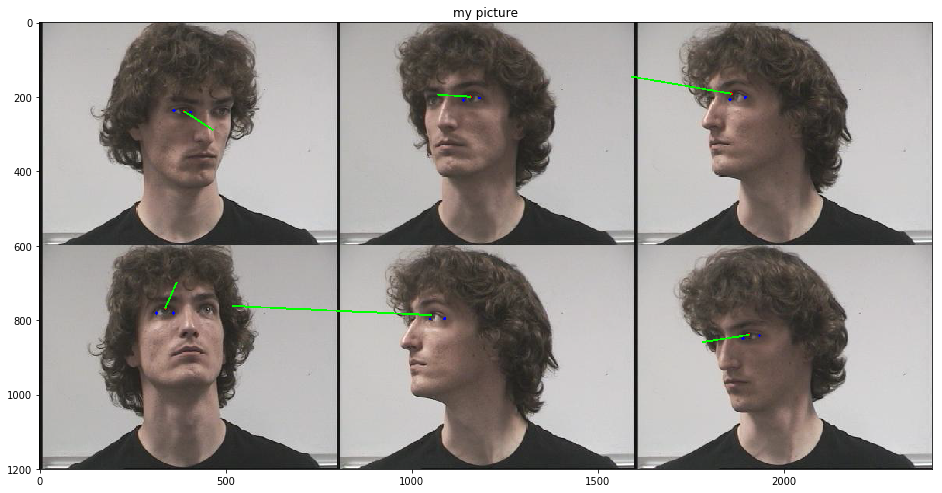

In [42]:

#SOLVER FOR PNP
cameraMatrix = np.eye(3)  #A checker en fct de l'optique choisie
distCoeffs = np.zeros((5,1))
eyeConst=1.5

#IMAGE POI FOR 7 POINT
FacePOI = np.zeros((7,2),dtype=np.float32)
ThreeDFacePOI = np.zeros((7,3),dtype=np.float32)
#RIGHTHEAR
ThreeDFacePOI[0,0] = -6
ThreeDFacePOI[0,1] = 0
ThreeDFacePOI[0,2] = -8
#LEFTHEAR
ThreeDFacePOI[1,0] = 6
ThreeDFacePOI[1,1] = 0
ThreeDFacePOI[1,2] = -8
#NOSE
ThreeDFacePOI[2,0] = 0
ThreeDFacePOI[2,1] = -4
ThreeDFacePOI[2,2] = 2.5
#RIGHTMOUTH
ThreeDFacePOI[3,0] = -5
ThreeDFacePOI[3,1] = -8
ThreeDFacePOI[3,2] = 0
#LEFTMOUTH
ThreeDFacePOI[4,0] = 5
ThreeDFacePOI[4,1] = -8
ThreeDFacePOI[4,2] = 0
#RIGHTEYE
ThreeDFacePOI[5,0] = -3
ThreeDFacePOI[5,1] = 0
ThreeDFacePOI[5,2] = -1
#LEFTEYE
ThreeDFacePOI[6,0] =3
ThreeDFacePOI[6,1] = 0
ThreeDFacePOI[6,2] = 1

def rotMatFromEye(eyeData):
    #print eyeData
    eyeDiameter = eyeConst*Distance(eyeData[1][0],eyeData[1][1])
    eyeCenter = ((eyeData[1][0][0]+eyeData[1][1][0])/2.0,(eyeData[1][0][1]+eyeData[1][1][1])/2.0)
    eyePos=eyeData[0]
    #HERE WE CONSTRUCT A MATRIX OF A BASE WHERE THE UNIT IS THE DIAMETER OF THE EYE AND AXIS OF THIS
    mainEyeAxis=((eyeData[1][0][0]-eyeData[1][1][0]),(eyeData[1][0][1]-eyeData[1][1][1]))
    secondEyeAxis=perpendicular(mainEyeAxis)

    reverseTransitionMatrix=(mainEyeAxis,secondEyeAxis)

    transitionMatrix= np.linalg.inv(reverseTransitionMatrix)
    eyeCenterInEyeRef=np.dot(transitionMatrix,eyeCenter)
    eyeCenterInEyeRef[1]=eyeCenterInEyeRef[1]+0.2

    eyePosInEyeRef=np.dot(transitionMatrix,eyePos)

    eyeOffset=eyePosInEyeRef-eyeCenterInEyeRef

    eyeOffset=[clamp(eyeOffset[0],-0.99,0.99),clamp(eyeOffset[1],-0.99,0.99)]
    #Now we get the rotation values
    thetay=-np.arcsin(eyeOffset[0])*eyeConst
    thetax=np.arcsin(eyeOffset[1])*eyeConst
    #Aaand the rotation matrix
    rot=eulerAnglesToRotationMatrix([thetax,thetay,0])
    #print rot
    return rot

#Given the data from a faceExtract
def getCoordFromFace(FacePOI,eyeData):
    #SOLVER FOR PNPs
    distCoeffs = np.zeros((5,1))
    #HARDCODED CAM PARAMS
    width=2402
    height=1201
    maxSize=max(width,height)
    cameraMatrix=np.array([[maxSize, 0, width/2.0],[0,maxSize,height/2.0],[0,0,1]], np.int32)
    retval,rvec, tvec =  cv2.solvePnP(ThreeDFacePOI, FacePOI, cameraMatrix, distCoeffs);
    rt, jacobian= cv2.Rodrigues(rvec)
    rot2=rotMatFromEye(eyeData)

    origin= [tvec[0][0],tvec[1][0],tvec[2][0]]
    headDir=np.dot(rot2,np.dot(rt,[0,0,1]))
    camPlaneOrthVector=[0,0,1]
    pointOnPlan=[0,0,0]
    return intersectionWithPlan(origin,headDir, camPlaneOrthVector,pointOnPlan)

def perpendicular( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b
def clamp(n, minn, maxn):
    if n < minn:
        return minn
    elif n > maxn:
        return maxn
    else:
        return n
    

def eulerAnglesToRotationMatrix(theta) :
    R_x = np.array([[1,         0,                  0                   ],
                    [0,         math.cos(theta[0]), -math.sin(theta[0]) ],
                    [0,         math.sin(theta[0]), math.cos(theta[0])  ]
                    ])
    R_y = np.array([[math.cos(theta[1]),    0,      math.sin(theta[1])  ],
                    [0,                     1,      0                   ],
                    [-math.sin(theta[1]),   0,      math.cos(theta[1])  ]
                    ])
    R_z = np.array([[math.cos(theta[2]),    -math.sin(theta[2]),    0],
                    [math.sin(theta[2]),    math.cos(theta[2]),     0],
                    [0,                     0,                      1]
                    ])
    R = np.dot(R_z, np.dot( R_y, R_x ))

    return R


def intersectionWithPlan(linePoint,lineDir, planOrth, planPoint):
    d=np.dot(np.subtract(linePoint,planPoint),planOrth)/(np.dot(lineDir,planOrth))
    intersectionPoint=np.subtract(np.multiply(d,lineDir),linePoint)
    return intersectionPoint


for index,POI in enumerate(faces_data):
    viewPoint=getCoordFromFace(POI[0],eye_centers[index])
    cv2.line(test,(int(eye_centers[index][0][0]),int(eye_centers[index][0][1])),(int(eye_centers[index][0][0]-viewPoint[0]),int(eye_centers[index][0][1]-viewPoint[1])),(0,255,0),4, -1)

plt.figure(figsize=(16,16))
plt.imshow(test)
plt.title('my picture')
plt.show()
